In [1]:
import pandas as pd #for data importing and manupulation
import numpy as np  #for data manupulation and cleaning
import seaborn as sns # data visualization
import matplotlib.pyplot as plt # data visualization
%matplotlib inline 

In [41]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
sub = pd.read_csv('sample_submission (2).csv')

In [42]:
from catboost import CatBoostClassifier

In [43]:
#Imputing missing values for both train and test
train.fillna(0, inplace=True)
test.fillna(0,inplace=True)

In [44]:
train.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [45]:
test_id = test['Customer Id']

In [46]:
train = train.drop('Customer Id', axis=1)
test = test.drop('Customer Id', axis=1)

In [47]:
X = train.drop('Claim', axis=1)
y = train.Claim

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
# Split the data into 30% validation and 70% training
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=101)

In [50]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

In [51]:
model=CatBoostClassifier(iterations=800, #leaf_estimation_iterations=10,#800
                              learning_rate=0.1,
                              depth=4,#loss_function='MultiClass',#,scale_pos_weight=200,
                             #l2_leaf_reg=5,
                             bootstrap_type='Bernoulli',
                              subsample=0.9,
                              eval_metric='AUC',
                              metric_period=20,
                                   #class_weight s=0,
                              #od_type='Iter',
                              #od_wait=45,
                              #random_seed=10,
                              allow_writing_files=False)

In [52]:
model.fit(X_train, y_train, cat_features=categorical_features_indices, eval_set=(X_val, y_val))

0:	test: 0.6886216	best: 0.6886216 (0)	total: 441ms	remaining: 5m 52s
20:	test: 0.7206297	best: 0.7206297 (20)	total: 2.47s	remaining: 1m 31s
40:	test: 0.7229247	best: 0.7229247 (40)	total: 4.07s	remaining: 1m 15s
60:	test: 0.7231703	best: 0.7231703 (60)	total: 5.56s	remaining: 1m 7s
80:	test: 0.7235242	best: 0.7235242 (80)	total: 6.97s	remaining: 1m 1s
100:	test: 0.7241624	best: 0.7241624 (100)	total: 8.5s	remaining: 58.9s
120:	test: 0.7229487	best: 0.7241624 (100)	total: 10.7s	remaining: 59.8s
140:	test: 0.7237857	best: 0.7241624 (100)	total: 13.2s	remaining: 1m 1s
160:	test: 0.7245981	best: 0.7245981 (160)	total: 14.8s	remaining: 58.6s
180:	test: 0.7264586	best: 0.7264586 (180)	total: 17s	remaining: 58.3s
200:	test: 0.7254653	best: 0.7264586 (180)	total: 18.7s	remaining: 55.7s
220:	test: 0.7243212	best: 0.7264586 (180)	total: 20.4s	remaining: 53.5s
240:	test: 0.7244295	best: 0.7264586 (180)	total: 22.2s	remaining: 51.5s
260:	test: 0.7238793	best: 0.7264586 (180)	total: 23.7s	remaini

In [53]:
y_pred=model.predict_proba(test)[:, 1]

In [54]:
from sklearn.metrics import roc_auc_score

In [55]:
print(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))

0.726458605155


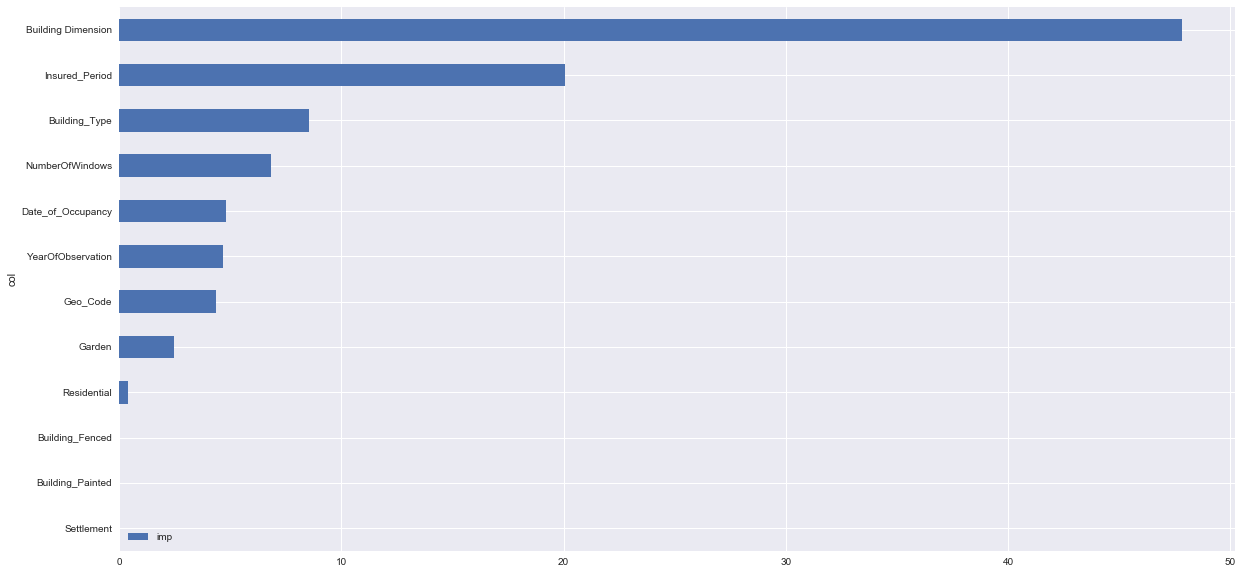

In [37]:
fea_imp = pd.DataFrame({'imp':model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')    

In [56]:
d = {"Customer Id": test_id, 'Claim': y_pred}
test_predictions = pd.DataFrame(data=d)
test_predictions = test_predictions[["Customer Id", 'Claim']]

In [57]:
test_predictions.head()

,Customer Id,Claim
0,H11920,0.101533
1,H11921,0.094347
2,H9805,0.069704
3,H7493,0.180605
4,H7494,0.169136


In [58]:
test_predictions.to_csv('i2.csv', index=False)